In [1]:
# =====================================
# 🧩 1️⃣ 라이브러리 설치
# =====================================
!pip install mediapipe opencv-python numpy pandas moviepy

# =====================================
# 📂 2️⃣ 영상 업로드
# =====================================
from google.colab import files
uploaded = files.upload()
video_path = list(uploaded.keys())[0]
print(f"✅ 업로드 완료: {video_path}")

import mediapipe as mp
import cv2
import pandas as pd
import numpy as np

# =====================================
# 🧠 3️⃣ MediaPipe로 키포인트 추출
# =====================================
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    model_complexity=1,
                    enable_segmentation=False,
                    min_detection_confidence=0.5)

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
keypoints_list = []
frame_idx = 0

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(frame_rgb)

    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark

        keypoints = {'frame': frame_idx}
        for i, lm in enumerate(landmarks):
            keypoints[f'x_{i}'] = lm.x
            keypoints[f'y_{i}'] = lm.y
            keypoints[f'z_{i}'] = lm.z
            keypoints[f'v_{i}'] = lm.visibility
        keypoints_list.append(keypoints)

    frame_idx += 1

cap.release()

df_key = pd.DataFrame(keypoints_list)
df_key.to_csv("/content/pose_keypoints.csv", index=False)
print(f"✅ 좌표 추출 완료 ({len(df_key)} 프레임, FPS={fps:.1f})")

# =====================================
# 📊 4️⃣ 자세 평가 + 감점 + 0.5초 지속 문제 처리
# + 자세별 점수/문제 발생 요약 추가 ✅
# =====================================
def analyze_posture_fixed(csv_path,
                          th_sh=0.04399,
                          th_head=0.01017):

    df = pd.read_csv(csv_path)
    VIS_THRESHOLD = 0.5
    k = 5  # 감점 민감도
    frame_duration = 1.0 / fps
    problem_frames = []
    feedback_records = []

    # ✅ 카테고리별 문제 프레임 저장
    shoulder_bad = []
    head_bad = []
    hand_bad = []

    def score_from_diff(diff, th):
        return 1.0 if diff <= th else max(1 - (diff - th) * k, 0)

    print("\n📌 사용 중인 고정 Threshold")
    print(f"어깨 Y diff → {th_sh:.5f}")
    print(f"고개 X diff → {th_head:.5f}")

    for _, row in df.iterrows():

        def get_part(idx):
            return (row[f'x_{idx}'], row[f'y_{idx}']) if row[f'v_{idx}'] >= VIS_THRESHOLD else None

        L_sh, R_sh = get_part(11), get_part(12)
        Nose = get_part(0)
        L_hand, R_hand = get_part(16), get_part(15)

        # 어깨 기울어짐
        diff_sh = abs(L_sh[1] - R_sh[1]) if (L_sh and R_sh) else th_sh
        shoulder_score = score_from_diff(diff_sh, th_sh)
        if shoulder_score < 0.9:
            shoulder_bad.append(int(row["frame"]))

        # 고개 좌/우 쏠림
        if Nose and L_sh and R_sh:
            shoulder_mid_x = (L_sh[0] + R_sh[0]) / 2
            diff_head = abs(Nose[0] - shoulder_mid_x)
        else:
            diff_head = th_head
        head_score = score_from_diff(diff_head, th_head)
        if head_score < 0.9:
            head_bad.append(int(row["frame"]))

        # 손 위치
        diff_hand = 0
        hand_score = 1.0
        if L_hand and R_hand and L_sh and R_sh:
            diff_hand = max(L_sh[1] - L_hand[1], R_sh[1] - R_hand[1])
            if diff_hand > 0:
                hand_score = max(1 - diff_hand * k, 0)
        if hand_score < 0.9:
            hand_bad.append(int(row["frame"]))

        avg_score = np.mean([shoulder_score, head_score, hand_score])

        feedback_records.append({
            "frame": int(row["frame"]),
            "shoulder": shoulder_score,
            "head_tilt": head_score,
            "hand": hand_score,
            "avg_score": avg_score,
            "shoulder_diff": diff_sh,  # 추가
            "head_diff": diff_head     # 추가
        })

        if avg_score < 0.9:
            problem_frames.append(int(row["frame"]))

    # ---------------------
    # 연속 0.5초 이상 문제 구간 정리
    # ---------------------
    def merge(frames):
        sections = []
        if not frames:
            return sections
        start = frames[0]
        prev = start
        for f in frames[1:]:
            if f == prev + 1:
                prev = f
            else:
                sections.append((start, prev))
                start = f
                prev = f
        sections.append((start, prev))
        return [(s, e) for s, e in sections if (e - s + 1) * frame_duration >= 0.5]

    shoulder_sections = merge(shoulder_bad)
    head_sections = merge(head_bad)
    hand_sections = merge(hand_bad)

    df_out = pd.DataFrame(feedback_records)

    # ✅ 전체 점수
    total_score = df_out["avg_score"].mean() * 100
    shoulder_mean = df_out["shoulder"].mean() * 100
    head_mean = df_out["head_tilt"].mean() * 100
    hand_mean = df_out["hand"].mean() * 100

    df_out.to_csv("/content/pose_feedback.csv", index=False)

    print("\n✅ 분석 완료!")
    print(f"🎯 전체 자세 점수: {total_score:.1f}점")
    print(f" ├ 어깨 점수: {shoulder_mean:.1f}")
    print(f" ├ 고개 점수: {head_mean:.1f}")
    print(f" └ 손 점수: {hand_mean:.1f}")

    def print_section(label, sections):
        if sections:
            print(f"\n⚠ {label} 문제 지속 구간:")
            for s, e in sections:
                ts = s * frame_duration
                te = e * frame_duration
                dur = (e - s + 1) * frame_duration
                print(f"- {ts:.2f}초 → {te:.2f}초 (총 {dur:.2f}초)")
        else:
            print(f"\n✅ {label} 문제 없음! 👍")

    print_section("어깨", shoulder_sections)
    print_section("고개", head_sections)
    print_section("손", hand_sections)

    return df_out, total_score, (shoulder_sections, head_sections, hand_sections)

# =====================================
# ✅ 실행
# =====================================
feedback_df, total_score, problem_sections = analyze_posture_fixed("/content/pose_keypoints.csv")
feedback_df.head()


Saving WIN_20251010_11_31_25_Pro.mp4 to WIN_20251010_11_31_25_Pro.mp4
✅ 업로드 완료: WIN_20251010_11_31_25_Pro.mp4


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


✅ 좌표 추출 완료 (2102 프레임, FPS=16.6)

📌 사용 중인 고정 Threshold
어깨 Y diff → 0.04399
고개 X diff → 0.01017

✅ 분석 완료!
🎯 전체 자세 점수: 98.5점
 ├ 어깨 점수: 99.3
 ├ 고개 점수: 96.3
 └ 손 점수: 100.0

⚠ 어깨 문제 지속 구간:
- 111.57초 → 112.72초 (총 1.20초)

⚠ 고개 문제 지속 구간:
- 42.25초 → 43.63초 (총 1.44초)
- 45.92초 → 46.94초 (총 1.08초)
- 47.78초 → 48.32초 (총 0.60초)
- 51.81초 → 55.61초 (총 3.85초)
- 56.75초 → 57.71초 (총 1.02초)
- 58.80초 → 59.34초 (총 0.60초)
- 96.95초 → 101.10초 (총 4.21초)
- 101.40초 → 102.18초 (총 0.84초)
- 102.79초 → 103.57초 (총 0.84초)
- 104.17초 → 104.77초 (총 0.66초)

✅ 손 문제 없음! 👍


,frame,shoulder,head_tilt,hand,avg_score,shoulder_diff,head_diff
0,0,1.0,0.955827,1.0,0.985276,0.037962,0.019005
1,1,1.0,0.947710,1.0,0.982570,0.038259,0.020628
2,2,1.0,0.947025,1.0,0.982342,0.038798,0.020765
3,3,1.0,0.942024,1.0,0.980675,0.038737,0.021765
4,4,1.0,0.942641,1.0,0.980880,0.038816,0.021642


In [ ]:
df_feedback = pd.read_csv("/content/pose_feedback.csv")
print(df_feedback.columns)
df_feedback.head()

Index(['frame', 'shoulder', 'head_tilt', 'avg_score', 'shoulder_diff',
       'head_diff'],
      dtype='object')


,frame,shoulder,head_tilt,avg_score,shoulder_diff,head_diff
0,0,1.0,1.0,1.0,0.015832,0.001833
1,1,1.0,1.0,1.0,0.005537,0.000376
2,2,1.0,1.0,1.0,0.005635,0.002775
3,3,1.0,1.0,1.0,0.008394,0.004311
4,4,1.0,1.0,1.0,0.009391,0.004229


✅ JSON 저장 완료: /content/feedback_timeline.json
🚨 문제구간: 10개

🎯 예시 출력:
[
  {
    "start_time": 9.07,
    "end_time": 11.5,
    "issue": "shoulder",
    "message": "왼쪽 어깨가 올라갔습니다. 양 어깨를 수평으로 맞추어주세요."
  },
  {
    "start_time": 43.9,
    "end_time": 45.17,
    "issue": "shoulder",
    "message": "왼쪽 어깨가 올라갔습니다. 양 어깨를 수평으로 맞추어주세요."
  },
  {
    "start_time": 0.0,
    "end_time": 1.27,
    "issue": "head_tilt",
    "message": "고개가 왼쪽로 기울어 있습니다. 천천히 중앙으로 맞춰주세요."
  },
  {
    "start_time": 23.27,
    "end_time": 24.3,
    "issue": "head_tilt",
    "message": "고개가 왼쪽로 기울어 있습니다. 천천히 중앙으로 맞춰주세요."
  },
  {
    "start_time": 26.3,
    "end_time": 28.53,
    "issue": "head_tilt",
    "message": "고개가 왼쪽로 기울어 있습니다. 천천히 중앙으로 맞춰주세요."
  }
]


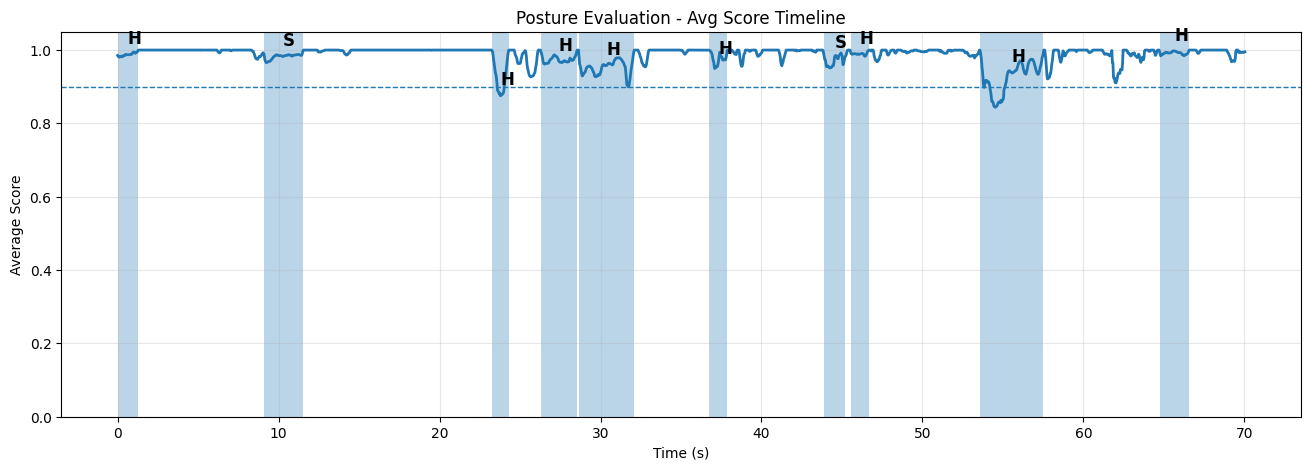

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ============================================
# ✅ 데이터 로드 & 필수 컬럼 존재 확인
# ============================================
df = pd.read_csv("/content/pose_feedback.csv")

required_cols = ["shoulder_diff", "head_diff", "hand"]
missing = [c for c in required_cols if c not in df.columns]

if missing:
    raise ValueError(f"⚠ CSV에 필수 컬럼 없음 → {missing}\n\n"
                     f"✅ '좌표차이 분석 코드'가 먼저 실행되어야 합니다.")

# ============================================
# 📝 1️⃣ 문제별 메시지 정의
# ============================================
advice_map = {
    "shoulder": "{side} 어깨가 올라갔습니다. 양 어깨를 수평으로 맞추어주세요.",
    "head_tilt": "고개가 {side}로 기울어 있습니다. 천천히 중앙으로 맞춰주세요.",
    "hand": "손은 어깨 아래 위치로 유지해주세요."
}

# ============================================
# 2️⃣ React 타임라인용 피드백 JSON 생성 (정자세 Threshold 기반)
# ============================================
def generate_react_feedback_json(feedback_df, output_json_path, fps=30, min_duration=1.0,
                                 th_sh=0.04399, th_head=0.01017):
    alerts = []

    for col in ["shoulder", "head_tilt", "hand"]:
        if col == "shoulder":
            diff_col = "shoulder_diff"
            threshold = th_sh
        elif col == "head_tilt":
            diff_col = "head_diff"
            threshold = th_head
        else:
            diff_col = None

        # 문제 프레임 탐지
        if col in ["shoulder", "head_tilt"]:
            problem_idx = feedback_df.index[feedback_df[diff_col].abs() > threshold].tolist()
        else:
            problem_idx = feedback_df.index[feedback_df["hand"] < 1.0].tolist()

        if not problem_idx:
            continue

        # 연속 구간 묶기
        group_ids = (pd.Series(problem_idx).diff() > 1).cumsum()
        grouped = pd.DataFrame({"frame": problem_idx, "group": group_ids})

        for g_id, g_frames in grouped.groupby("group"):
            start_f = g_frames['frame'].min()
            end_f = g_frames['frame'].max()
            duration = (end_f - start_f) / fps

            if duration < min_duration:
                continue

            if col == "shoulder":
                mean_diff = feedback_df.loc[start_f:end_f, "shoulder_diff"].mean()
                side = "왼쪽" if mean_diff > 0 else "오른쪽"
                message = advice_map[col].format(side=side)

            elif col == "head_tilt":
                mean_diff = feedback_df.loc[start_f:end_f, "head_diff"].mean()
                side = "왼쪽" if mean_diff > 0 else "오른쪽"
                message = advice_map[col].format(side=side)

            else:
                message = advice_map[col]

            alerts.append({
                "start_time": round(start_f / fps, 2),
                "end_time": round(end_f / fps, 2),
                "issue": col,
                "message": message
            })

    json_data = {"feedback_timeline": alerts}

    with open(output_json_path, "w", encoding="utf-8") as f:
        json.dump(json_data, f, ensure_ascii=False, indent=2)

    print(f"✅ JSON 저장 완료: {output_json_path}")
    print(f"🚨 문제구간: {len(alerts)}개")
    return json_data


# ============================================
# 3️⃣ 피드백 JSON 생성 실행
# ============================================
feedback_json = generate_react_feedback_json(
    feedback_df=df,
    output_json_path="/content/feedback_timeline.json",
    fps=30,
    min_duration=1.0
)

print("\n🎯 예시 출력:")
print(json.dumps(feedback_json["feedback_timeline"][:5], ensure_ascii=False, indent=2))

# ============================================
# Graphs
# ============================================
with open("/content/feedback_timeline.json", "r", encoding="utf-8") as f:
    feedback_json = json.load(f)

fps = 30
time_sec = np.arange(len(df)) / fps

'''# Shoulder Graph
plt.figure(figsize=(14,4))
plt.plot(time_sec, df['shoulder_diff'], linewidth=2)
for alert in feedback_json['feedback_timeline']:
    if alert['issue'] == "shoulder":
        plt.axvspan(alert['start_time'], alert['end_time'], alpha=0.3)
plt.xlabel("Time (s)")
plt.ylabel("Left - Right (px)")
plt.title("Shoulder Height Difference")
plt.show()

# Head Tilt Graph
plt.figure(figsize=(14,4))
plt.plot(time_sec, df['head_diff'], linewidth=2)
for alert in feedback_json['feedback_timeline']:
    if alert['issue'] == "head_tilt":
        plt.axvspan(alert['start_time'], alert['end_time'], alpha=0.3)
plt.xlabel("Time (s)")
plt.ylabel("Head Tilt (px)")
plt.title("Head Tilt Difference")
plt.show()

# Hand Graph
plt.figure(figsize=(14,4))
plt.plot(time_sec, df['hand'], linewidth=2)
for alert in feedback_json['feedback_timeline']:
    if alert['issue'] == "hand":
        plt.axvspan(alert['start_time'], alert['end_time'], alpha=0.3)
plt.xlabel("Time (s)")
plt.ylabel("Hand Score")
plt.title("Hand Position Score")
plt.show()'''

# ============================================
# ✅ 평균 점수 타임라인 시각화
# ============================================
avg_scores = df['avg_score'].values

plt.figure(figsize=(16, 5))
plt.plot(time_sec, avg_scores, linewidth=2)

# 임계선 표시
plt.axhline(0.9, linestyle='--', linewidth=1)

# 문제구간 하이라이트 + 라벨링(S/H/Hd)
for alert in feedback_json["feedback_timeline"]:
    s, e = alert["start_time"], alert["end_time"]
    label = ""
    if alert["issue"] == "shoulder": label = "S"
    elif alert["issue"] == "head_tilt": label = "H"
    elif alert["issue"] == "hand": label = "Hd"

    # 배경 음영
    plt.axvspan(s, e, alpha=0.3)

    # 라벨 표시 (구간 중간 위치)
    mid = (s + e) / 2
    height = df.loc[int(mid * fps), "avg_score"]
    plt.text(mid, height + 0.03, label, fontsize=12, fontweight='bold')

plt.xlabel("Time (s)")
plt.ylabel("Average Score")
plt.ylim(0, 1.05)
plt.title("Posture Evaluation - Avg Score Timeline")
plt.grid(alpha=0.3)
plt.show()


